# note: do evaluation in (N,C,L) format, this way the accuracy is better reflected, and we still get stel predictions over time

# TODO: historic average and need a map of time step to historic step...
- ### The number of hours of the division should give an indication of cell plot scales 
- ### Separate model results and model metrics: allows for less disc space being used


### What will have more weight false positive or false negative? Obviously false positive is a lot more important. Intuitively put, recisions measures to how many of our class guesses did we waste, where as recall measures how many of the actual occurrences did we catch.

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report

In [2]:
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult
from models.baseline_models import ExponentialMovingAverage,\
                UniformMovingAverage, TriangularMovingAverage, HistoricAverage

In [3]:
os.listdir("./data/processed")

['.DS_Store',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [4]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type
conf.device = device

2019-10-29T23:48:21 | root | INFO | =====================================BEGIN=====================================
2019-10-29T23:48:21 | root | INFO | Device: cpu


2019-10-29T23:48:21 | root | INFO | Data shapes of files in generated_data.npz
2019-10-29T23:48:21 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-29T23:48:21 | root | INFO | 	crime_types_grids shape (730, 10, 47, 33)
2019-10-29T23:48:21 | root | INFO | 	crime_grids shape (730, 1, 47, 33)
2019-10-29T23:48:21 | root | INFO | 	tract_count_grids shape (730, 1, 47, 33)
2019-10-29T23:48:21 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-29T23:48:21 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-29T23:48:21 | root | INFO | 	time_vectors shape (731, 52)
2019-10-29T23:48:21 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-29T23:48:21 | root | INFO | 	x_range shape (33,)
2019-10-29T23:48:21 | root | INFO | 	y_range shape (47,)
2019-10-29T23:48:21 | root | INFO | 	t_range shape (731,)
threshold: -1 - targets.shape: (729, 1, 770)
class distribution: {0.0: 0.564881620437176, 1.0: 0.435118379562824}


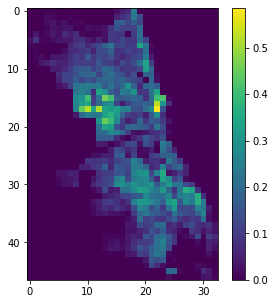

In [5]:
# visualize the cells that we are dropping
conf.shaper_threshold = 0
conf.shaper_top_k = -1

for i in [-1]:
    conf.shaper_top_k = i
    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    print(f"threshold: {i} - targets.shape: {data_group.targets.shape}")
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    print(f"class distribution: {dist}")
    
    sorted_indices = data_group.sorted_indices
    
    plt.figure(figsize=(5,5))
    plt.imshow(data_group.shaper.unsqueeze(data_group.crimes)[:,0].mean(0))
    plt.colorbar()
    plt.show()

In [6]:
conf.shaper_threshold = 0
conf.shaper_top_k = -1

# CRIME DATA
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-10-29T23:48:25 | root | INFO | Data shapes of files in generated_data.npz
2019-10-29T23:48:25 | root | INFO | 	crime_feature_indices shape (10,)
2019-10-29T23:48:25 | root | INFO | 	crime_types_grids shape (730, 10, 47, 33)
2019-10-29T23:48:25 | root | INFO | 	crime_grids shape (730, 1, 47, 33)
2019-10-29T23:48:25 | root | INFO | 	tract_count_grids shape (730, 1, 47, 33)
2019-10-29T23:48:25 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-10-29T23:48:25 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-10-29T23:48:25 | root | INFO | 	time_vectors shape (731, 52)
2019-10-29T23:48:25 | root | INFO | 	weather_vectors shape (365, 11)
2019-10-29T23:48:25 | root | INFO | 	x_range shape (33,)
2019-10-29T23:48:25 | root | INFO | 	y_range shape (47,)
2019-10-29T23:48:25 | root | INFO | 	t_range shape (731,)


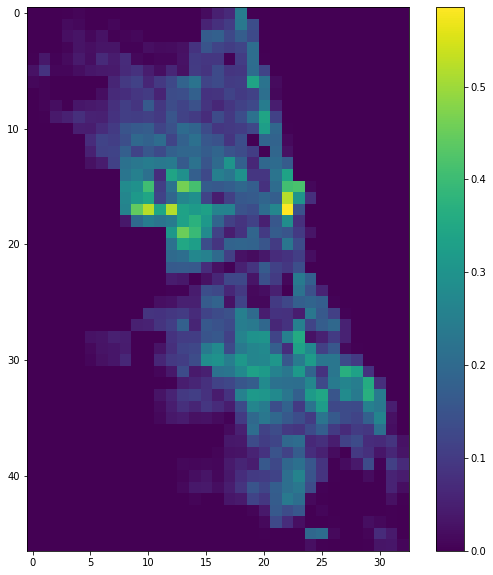

In [7]:
test_set_size = data_group.testing_set.target_shape[0]
crimes = data_group.shaper.unsqueeze(data_group.crimes)
im(crimes.mean(0)[0])
crimes = data_group.crimes
t_range = data_group.t_range

In [8]:
model_results = []

## Historic average model

In [54]:
# time step in this context is used for 
freqstr = t_range.freqstr
time_step = int(24 / int(freqstr[:freqstr.find("H")]))

print(f"using time step: {time_step}")

ha = HistoricAverage(step=time_step)
all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
tst_targets = data_group.testing_set.targets
all_crimes_ha = ha(all_crimes)  # todo re-write using the convolve function - it loses the 
tst_crimes_ha = all_crimes_ha[-len(tst_targets):]
trn_crimes_ha = all_crimes_ha[time_step+1:len(tst_targets)] # skip all the nan values
trn_targets = all_targets[time_step+1:len(tst_targets)]


N,_,L = tst_targets.shape


thresh = best_threshold(trn_targets, trn_crimes_ha) # should only come from the train predictions

y_true = tst_targets
probas_pred = tst_crimes_ha
y_pred = get_y_pred(thresh, probas_pred)  # might want to do this for each cell either?

# alternatively - might want to do this for each cell either?
# thresholds_ha = []
# y_pred = np.empty_like(y_true)
# for i in range(L):
#     # important note thresh should eb for the training data
#     thresh = best_threshold(y_true=trn_targets[:,i],probas_pred=trn_crimes_ha[:,i], verbose=False)  
#     thresholds_ha.append(thresh)
#     y_pred[:,i] = get_y_pred(thresh, probas_pred[:,i])
    
ha_model_result = ModelResult(model_name=f"HA One Thresh {time_step}",
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=data_group.testing_set.t_range,
                                shaper=data_group.shaper)

model_results.append(ha_model_result)

using time step: 1
2019-10-29T23:22:49 | root | INFO | f1_score: 0.7256978172389156 at index 84344, new threshold 0.0883857531569978


In [56]:
import pickle

In [60]:
with open("ha_model_result.pkl","wb") as file:
    pickle.dump(ha_model_result, file)

In [61]:
with open("ha_model_result.pkl","rb") as file:
    old_result = pickle.load(file)

In [71]:
ha_model_result.y_pred.shape
# im(old_result.shaper.unsqueeze(old_result.y_true).mean(0)[0])

(364980,)

## Mean of training data as future prediction

In [ ]:
# Mean of training data as future prediction
trn_crimes = data_group.training_set.crimes

# only get the mean of the trn_set
crimes_mean = np.mean(trn_crimes[:,0],axis=0,keepdims=True)  # keep dims used to make scalar product easy
crimes_ones = np.ones_like(data_group.testing_set.targets)
y_pred_sparse = crimes_mean*crimes_ones
tst_targets = data_group.testing_set.targets

N,L = tst_targets.shape
targets_shape = N,L


y_pred_dense = y_pred_sparse

probas_pred = y_pred_dense.flatten()
y_true = tst_targets.flatten()
thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
y_pred = np.copy(probas_pred)
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh] = 0

mean_model_result = ModelResult(model_name="Train Mean",
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=data_group.testing_set.t_range,
                                shaper=data_group.shaper)

model_results.append(mean_model_result)

## Rolling mean of all data 

In [ ]:
for window_len in [time_step*7]:
    for alpha in [1e1, 1e2,1e-1]:
        ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)
        all_crimes = data_group.crimes[:,0]
        tst_targets = data_group.testing_set.targets
        all_crimes_ma = ma(all_crimes)
        tst_crimes_ma = all_crimes_ma[-len(tst_targets):]

        N,L = tst_targets.shape
        targets_shape = N,L

        targets_dense = tst_targets

        y_pred_dense = tst_crimes_ma

        probas_pred = y_pred_dense.flatten()
        y_true = targets_dense.flatten()

        thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
        y_pred = np.copy(probas_pred)
        y_pred[y_pred >= thresh] = 1
        y_pred[y_pred < thresh] = 0

        ma_model_result = ModelResult(model_name=f"EMA window={window_len}, alpha={alpha}",
                                        y_true=y_true,
                                        y_pred=y_pred,
                                        probas_pred=probas_pred,
                                        t_range=data_group.testing_set.t_range,
                                        shaper=data_group.shaper)

        model_results.append(ma_model_result)

## Adding random noise to the predictions

In [ ]:
for noise_std in [0.4,0.8]:
    tst_crimes = data_group.testing_set.targets  # only mask the targets as the outputs


    noise = noise_std*np.random.randn(*np.shape(tst_crimes))
    # should be a flip seeing that the class distribution is so skew

    y_pred_sparse = tst_crimes + noise
    targets_dense = data_group.testing_set.targets
    y_pred_dense = y_pred_sparse

    probas_pred = y_pred_dense.flatten()
    
    N,L = targets_dense.shape
    targets_shape = N,L
    
    y_true = targets_dense.flatten()
    thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    noise_model_result = ModelResult(model_name=f"Noise model std={noise_std}",
                                    y_true=y_true,
                                    y_pred=y_pred,
                                    probas_pred=probas_pred,
                                    t_range=data_group.testing_set.t_range,
                                     shaper=data_group.shaper)

    model_results.append(noise_model_result)

In [ ]:
for result in model_results:
    print(result)

pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

In [ ]:
# todo create function do unflatten y_true, y_probs, and probas_true
# use shape of the model and just rnp.reshape


## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now

### Data Analysis Hawks-proces using the EM kernel

In [ ]:
# todo get average using convolutions given the kernel 

In [ ]:
from tick.plot import plot_hawkes_kernels
from tick.hawkes import SimuHawkesSumExpKernels, SimuHawkesMulti, \
    HawkesSumExpKern, HawkesEM


class IndHawkesModel:
    """
    Indipendent Hawkes Modles where all cells are indipendent
    
    Using Tikc library from:
    - https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html
    """

    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        self.baselines = []   
        self.kernels = []

    def fit(self, data):
        """
        data: (N,L)
        """
        N, L = data.shape
        self.baselines = []
        self.kernels = []

        # convert into format for the hawkes trainer
        for i in range(L):
            realizations = []
            data_counts = data[:,i]
            time_stamps = np.argwhere(data_counts).astype(np.float)
            realizations.append([time_stamps[:,0]])

            # kernel_discretization if set explicitly it overrides kernel_support and kernel_size
            # todo: have kernel values be set by conf_dict
            em = HawkesEM(kernel_discretization=np.arange(self.kernel_size).astype(np.float),
                          n_threads=8,
                          verbose=False,
                          tol=1e-3,
                          max_iter=1000)
            em.fit(realizations)
            baseline = em.baseline.flatten()[0]
            kernel = em.kernel.flatten()
            self.baselines.append(baseline)
            self.kernels.append(kernel)

        
    def transform(self, data):
        # todo consider training saving a kernel AND baseline for each cell
        # kernels -> (N,L,kernel_size)
        # baselines -> (N,L,1)
        N,L = np.shape(data)
        result = np.empty_like(data)
        for i in range(L):    
            result[:,i] = self.baselines[i] + np.convolve(data[:,i],self.kernels[i])[:N]
        return result
    
    def fit_transform(self,data):
        self.fit(data)
        return self.transform(data)
    

In [ ]:
time_step

In [ ]:
trn_inpt = data_group.training_set.crimes[:,0]
trn_trg = data_group.training_set.targets

tst_inpt = data_group.testing_set.crimes[:,0]
tst_trg = data_group.testing_set.targets


N,L = np.shape(trn_inpt)

model = IndHawkesModel(kernel_size=time_step*21 + 1)
trn_out = model.fit_transform(trn_inpt)
tst_out = model.transform(tst_inpt)

y_true = tst_trg
probas_pred = tst_out
thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
y_pred = get_y_pred(thresh, probas_pred)  # might want to do this for each cell either?

hawkes_ind_model = ModelResult(model_name=f"Hawkes Independent Cells",
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=data_group.testing_set.t_range,
                               shaper=data_group.shaper)

model_results.append(hawkes_ind_model)

In [ ]:
kernels = np.array(model.kernels)
kernel_mean = np.mean(kernels,0)
kernel_std = np.std(kernels,0)
plt.plot(kernel_mean,alpha=.4)

x = np.concatenate([np.arange(len(kernel_mean)),np.arange(len(kernel_mean))[::-1]])
y = np.concatenate([kernel_mean-1.5*kernel_std,np.array(kernel_mean+1.5*kernel_std)[::-1]])
plt.fill(x,y,alpha=0.1)
plt.show()

In [ ]:
class HawkesModelGeneral:
    """
    Using the HawkesEM learner from Tick library
    
    Using Tikc library from:
    - https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html
    """

    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        self.kernel = None
        self.baseline = None
        self.em = None  

    def fit(self, data):
        """
        data: (N,L)
        """
        N, L = data.shape

        # convert into format for the hawkes trainer
        realizations = []
        for i in range(L):
            data_counts = data[:,i]
            time_stamps = np.argwhere(data_counts).astype(np.float)
        realizations.append([time_stamps[:,0]])

        # kernel_discretization if set explicitly it overrides kernel_support and kernel_size
        # todo: have kernel values be set by conf_dict
        self.em = HawkesEM(kernel_discretization=np.arange(self.kernel_size).astype(np.float),
                      n_threads=8,
                      verbose=False,
                      tol=1e-3,
                      max_iter=1000)
        self.em.fit(realizations)
        self.baseline = self.em.baseline.flatten()[0]
        self.kernel = self.em.kernel.flatten()

        
    def transform(self, data):
        # todo consider training saving a kernel AND baseline for each cell
        # kernels -> (N,L,kernel_size)
        # baselines -> (N,L,1)
        N,L = np.shape(data)
        result = np.empty_like(data)
        for i in range(L):    
            result[:,i] = self.baseline + np.convolve(data[:,i],self.kernel)[:N]
        return result
    
    def fit_transform(self,data):
        self.fit(data)
        return self.transform(data)
    
    def plot_kernel(self):
        plot_hawkes_kernels(self.em, hawkes=None, show=True)    

In [ ]:
trn_inpt = data_group.training_set.crimes[:,0]
trn_trg = data_group.training_set.targets

tst_inpt = data_group.testing_set.crimes[:,0]
tst_trg = data_group.testing_set.targets


N,L = np.shape(trn_inpt)

model = HawkesModelGeneral(kernel_size=time_step*20 + 1)
trn_out = model.fit_transform(trn_inpt)
tst_out = model.transform(tst_inpt)

y_true = tst_trg
probas_pred = tst_out
thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
y_pred = get_y_pred(thresh, probas_pred)  # might want to do this for each cell either?

hawkes_general_model = ModelResult(model_name=f"Hawkes General Model",
                                y_true=y_true,
                                y_pred=y_pred,
                                probas_pred=probas_pred,
                                t_range=data_group.testing_set.t_range,
                                   shaper=data_group.shaper)

model_results.append(hawkes_general_model)

plt.plot(model.kernel)

In [ ]:
# try and get cosine similarity between the kernels and baselines - should give a good indicaiton if we can compress

### ISSUE: is that we have some cells where no crime takes place - in either the testing or the training set
### thougths - look for data where to ranking of the cells actually changes with time - this will indicate how much crime actaully moves arround over time

In [ ]:
trn_inpt = data_group.training_set.crimes[:,0]
trn_trg = data_group.training_set.targets

tst_inpt = data_group.testing_set.crimes[:,0]
tst_trg = data_group.testing_set.targets


N,L = np.shape(trn_inpt)

model = IndHawkesModel(kernel_size=time_step*3 + 1)
trn_out = model.fit_transform(trn_inpt)
tst_out = model.transform(tst_inpt)

limit = 200
top_k = 10
i = 3000


# todo check how this influences the ROC and PR curves
def i2p(intensity):
    """
    intensity to probability
    """
    return 1 - np.exp(-1*intensity)
    
       
for i in range(top_k):
    for j in range(2):
        print(f"-------------------------------{j}----------------------------------")
        plt.figure(figsize=(10,2))
        plt.plot(tst_trg[i:i+limit,i])

        y_true = tst_trg[:,i]
        if j == 0:
            probas_pred = i2p(tst_out[:,i])
        else:     
            probas_pred = tst_out[:,i]

        thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
        y_pred = np.copy(probas_pred)
        y_pred[y_pred >= thresh] = 1
        y_pred[y_pred < thresh] = 0

        print(classification_report(y_true=y_true,y_pred=y_pred))

        plt.plot(y_pred[i:i+limit])
        plt.plot(probas_pred[i:i+limit])
    #     plt.ylim([0,1])
        plt.show()

        print(f"------------------------------------------------------------------")

        

In [ ]:
plt.plot(np.linspace(0,4,100))
plt.plot(i2p(np.linspace(0,4,100)))

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report

In [ ]:
for realization in realizations[:5]:#multi.timestamps:
    plt.figure(figsize=(10,1))
    for var in realization:
        plt.scatter(var, np.ones_like(var), alpha=.2, marker="|")    
    plt.show()

## sklearn dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='prior')
dummy.fit(X,y)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X,y)

print("log_reg:",accuracy_score(y, lr.predict_proba(X)[:,1].round()))

for strat in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strat)
    dummy.fit(X,y)
    print(f"dummy ({strat}):",accuracy_score(y, dummy.predict_proba(X)[:,1].round()))

    

## logistic regression model

In [ ]:

print(X.shape, y.shape)
get mean model as the starting position.
then train with only the new values to see the difference
print(data_group.crimes[:,0].shape)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')

clf..fit(X, y)
clf.predict(X[:2, :])
clf.predict_proba(X[:2, :]) 
clf.score(X, y)

print(f"clf.coef_ -> {clf.coef_}")

plt.figure(figsize=(15,15))
X = data_group.crimes[:400,0,data_group.sorted_indices]
aspect = X.shape[1]/X.shape[0]

plt.imshow(X=X,aspect=aspect,cmap='viridis')
plt.show()
    